In [1]:
import numpy as np
from scipy.stats import norm
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.animation as animation
from matplotlib import cm

# 1 PDE Methods: Binary and Barrier Options

# Barrier Options

# Question 3

### Analytical Formula

In [70]:
def delta_plus(z, tau, r, sigma):
    return (np.log(z) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    
def delta_minus(z, tau, r, sigma):
    return (np.log(z) + (r - 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    
def barrier_up_out_call_analytical_formula(S, K, B, r, sigma, T, t=0.0):
    if S >= B:
        return 0.0

    tau = T - t
    one = 1.0

    term1 = S * one * (norm.cdf(delta_plus(S / K, tau, r, sigma)) - norm.cdf(delta_plus(S / B, tau, r, sigma)))

    term2 = S * (B / S) ** (1 + (2 * r) / sigma**2)
    term2 *= (norm.cdf(delta_plus(B**2 / (K * S), tau, r, sigma)) - norm.cdf(delta_plus(B / S, tau, r, sigma)))

    term3 = K * np.exp(- tau * r) * one
    term3 *= (norm.cdf(delta_minus(S / K, tau, r, sigma)) - norm.cdf(delta_minus(S / B, tau, r, sigma)))

    term4 = K * np.exp(- tau * r) * one * (S / B) ** (1 - (2 * r / sigma**2))
    term4 *= (norm.cdf(delta_minus(B**2 / (K * S), tau, r, sigma)) - norm.cdf(delta_minus(B / S, tau, r, sigma)))

    price = term1 - term2 - term3 + term4
    return price


### Monte Carlo Simulation

In [79]:
def barrier_up_out_call_mc(S0, K, B, r, sigma, T, m=100, N=100_000, corrected=False, beta=0.5826):
    
    dt = T / m
    B_eff = B * np.exp(-beta * sigma * np.sqrt(dt)) if corrected else B

    S = np.full(N, S0, dtype=float)
    max_S = S.copy()

    for _ in range(m):
        #np.random.seed(42)
        Z = np.random.randn(N)
        S *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        max_S = np.maximum(max_S, S)

    payoff = np.where(max_S < B_eff, np.maximum(S - K, 0), 0)
    discounted = np.exp(-r * T) * payoff
    price = np.mean(discounted)
    stderr = np.std(discounted) / np.sqrt(N)

    return price, stderr

### Comparision the Price

### example

In [87]:
np.random.seed(42)

S0 = 100
K = 100
B = 120
r = 0.05
sigma = 0.2
T = 1.0

mc_price, mc_err = barrier_up_out_call_mc(S0, K, B, r, sigma, T, m=100, N=100000, corrected=False)
mc_corr_price, mc_corr_err = barrier_up_out_call_mc(S0, K, B, r, sigma, T, m=100, N=100000, corrected=True)

bs_closed = barrier_up_out_call_analytical_formula(S0, K, B, r, sigma, T)

print(f"Closed-form exact price     : {bs_closed:.6f}")
print(f"MC (no correction)          : {mc_price:.6f} ± {mc_err:.6f}")
print(f"MC (with correction)        : {mc_corr_price:.6f} ± {mc_corr_err:.6f}")


Closed-form exact price     : 1.176065
MC (no correction)          : 1.414509 ± 0.011201
MC (with correction)        : 1.179642 ± 0.009960


### wrt option parameters and model parameters

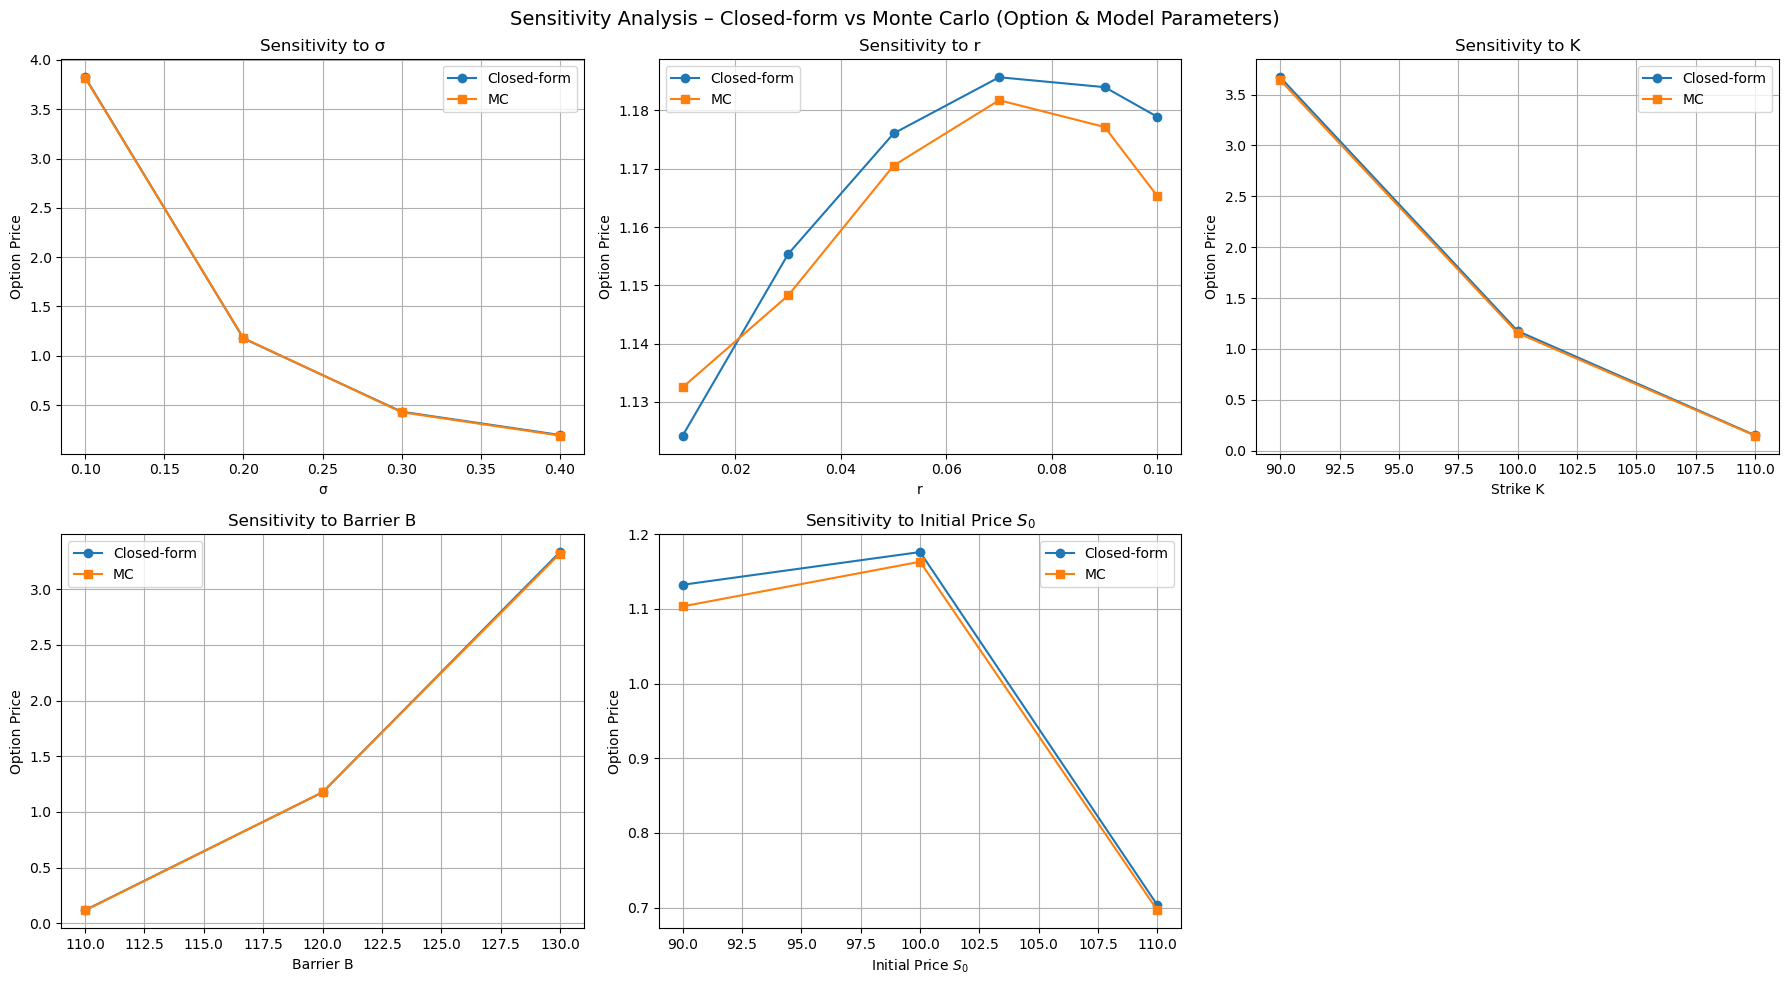

In [100]:
np.random.seed(42)

def comparison_model_parameters():
    S0 = 100
    T = 1.0
    B = 120
    base_r = 0.05
    base_sigma = 0.2
    base_K = 100

    sigmas = [0.1, 0.2, 0.3, 0.4]
    rs = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1]
    Ks = [90, 100, 110]
    Bs = [110, 120, 130]
    S0s = [90, 100, 110]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # σ sensitivity
    cf_vals, mc_vals = [], []
    for sigma in sigmas:
        cf = barrier_up_out_call_analytical_formula(S0, base_K, B, base_r, sigma, T)
        mc, _ = barrier_up_out_call_mc(S0, base_K, B, base_r, sigma, T, m=100, N=100000, corrected=True)
        cf_vals.append(cf)
        mc_vals.append(mc)
    axes[0, 0].plot(sigmas, cf_vals, label='Closed-form', marker='o')
    axes[0, 0].plot(sigmas, mc_vals, label='MC', marker='s')
    axes[0, 0].set_title("Sensitivity to σ")
    axes[0, 0].set_xlabel("σ")
    axes[0, 0].set_ylabel("Option Price")
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # r sensitivity
    cf_vals, mc_vals = [], []
    for r in rs:
        cf = barrier_up_out_call_analytical_formula(S0, base_K, B, r, base_sigma, T)
        mc, _ = barrier_up_out_call_mc(S0, base_K, B, r, base_sigma, T, m=100, N=100000, corrected=True)
        cf_vals.append(cf)
        mc_vals.append(mc)
    axes[0, 1].plot(rs, cf_vals, label='Closed-form', marker='o')
    axes[0, 1].plot(rs, mc_vals, label='MC', marker='s')
    axes[0, 1].set_title("Sensitivity to r")
    axes[0, 1].set_xlabel("r")
    axes[0, 1].set_ylabel("Option Price")
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # K sensitivity
    cf_vals, mc_vals = [], []
    for K in Ks:
        cf = barrier_up_out_call_analytical_formula(S0, K, B, base_r, base_sigma, T)
        mc, _ = barrier_up_out_call_mc(S0, K, B, base_r, base_sigma, T, m=100, N=100000, corrected=True)
        cf_vals.append(cf)
        mc_vals.append(mc)
    axes[0, 2].plot(Ks, cf_vals, label='Closed-form', marker='o')
    axes[0, 2].plot(Ks, mc_vals, label='MC', marker='s')
    axes[0, 2].set_title("Sensitivity to K")
    axes[0, 2].set_xlabel("Strike K")
    axes[0, 2].set_ylabel("Option Price")
    axes[0, 2].legend()
    axes[0, 2].grid(True)

    # B sensitivity
    cf_vals, mc_vals = [], []
    for B_val in Bs:
        cf = barrier_up_out_call_analytical_formula(S0, base_K, B_val, base_r, base_sigma, T)
        mc, _ = barrier_up_out_call_mc(S0, base_K, B_val, base_r, base_sigma, T, m=100, N=100000, corrected=True)
        cf_vals.append(cf)
        mc_vals.append(mc)
    axes[1, 0].plot(Bs, cf_vals, label='Closed-form', marker='o')
    axes[1, 0].plot(Bs, mc_vals, label='MC', marker='s')
    axes[1, 0].set_title("Sensitivity to Barrier B")
    axes[1, 0].set_xlabel("Barrier B")
    axes[1, 0].set_ylabel("Option Price")
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # S0 sensitivity
    cf_vals, mc_vals = [], []
    for S0_val in S0s:
        cf = barrier_up_out_call_analytical_formula(S0_val, base_K, B, base_r, base_sigma, T)
        mc, _ = barrier_up_out_call_mc(S0_val, base_K, B, base_r, base_sigma, T, m=100, N=100000, corrected=True)
        cf_vals.append(cf)
        mc_vals.append(mc)
    axes[1, 1].plot(S0s, cf_vals, label='Closed-form', marker='o')
    axes[1, 1].plot(S0s, mc_vals, label='MC', marker='s')
    axes[1, 1].set_title("Sensitivity to Initial Price $S_0$")
    axes[1, 1].set_xlabel("Initial Price $S_0$")
    axes[1, 1].set_ylabel("Option Price")
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    axes[1, 2].axis('off')

    plt.suptitle("Sensitivity Analysis – Closed-form vs Monte Carlo (Option & Model Parameters)", fontsize=14)
    plt.tight_layout()
    plt.show()

comparison_model_parameters()

### Convergence analysis w.r.t m

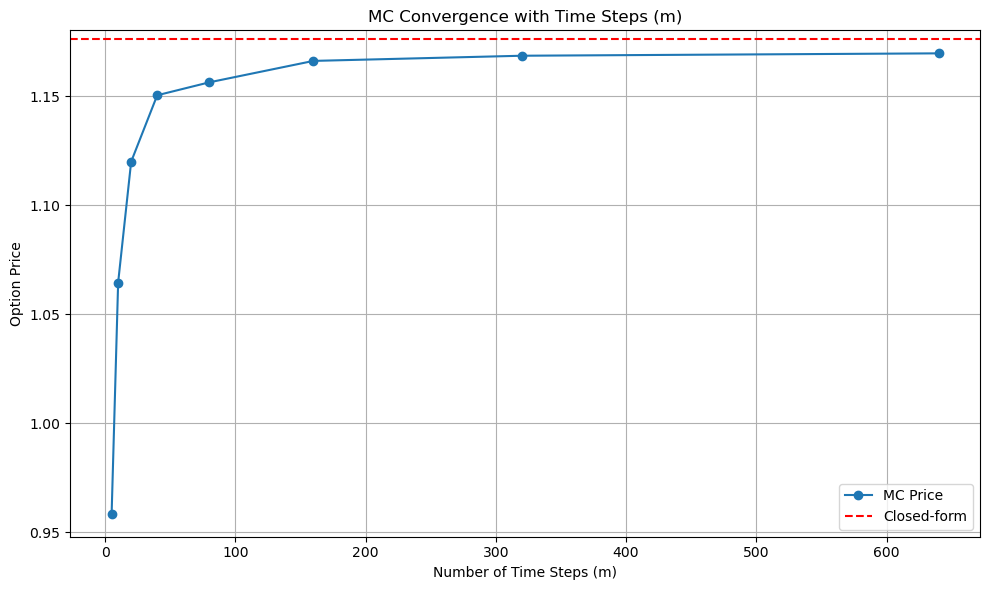

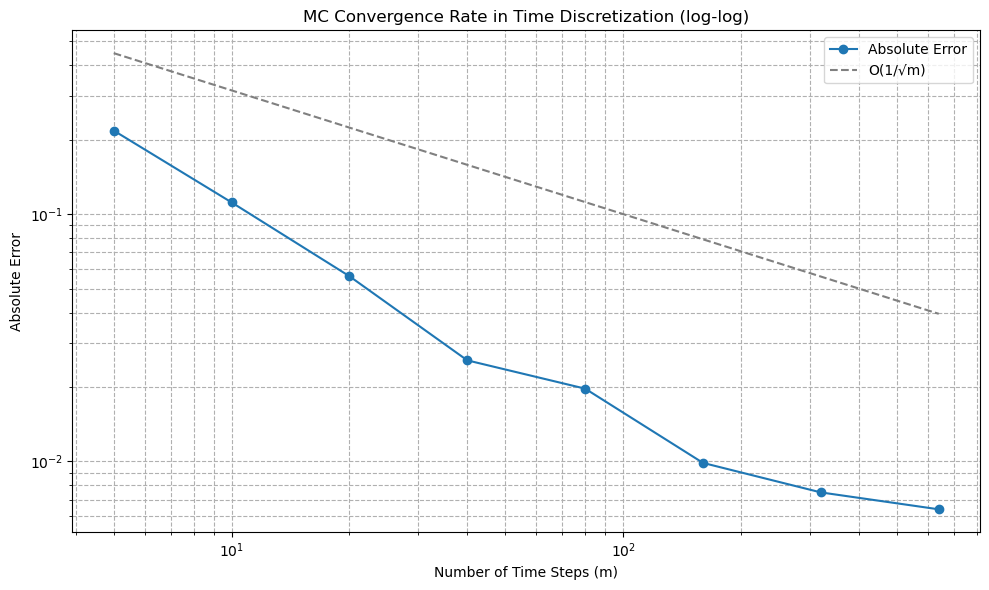

In [105]:
S0, K, B, r, sigma, T = 100, 100, 120, 0.05, 0.2, 1.0
N = 500_000
ms = [5, 10, 20, 40, 80, 160, 320, 640]

true_price = barrier_up_out_call_analytical_formula(S0, K, B, r, sigma, T)

mc_prices_m, mc_errors_m, abs_errors_m = [], [], []

np.random.seed(42)
for m in ms:
    price, err = barrier_up_out_call_mc(S0, K, B, r, sigma, T, m=m, N=N, corrected=True)
    mc_prices_m.append(price)
    mc_errors_m.append(err)
    abs_errors_m.append(abs(price - true_price))

plt.figure(figsize=(10, 6))
plt.plot(ms, mc_prices_m, marker='o', label='MC Price')
plt.axhline(true_price, color='red', linestyle='--', label='Closed-form')
plt.xlabel('Number of Time Steps (m)')
plt.ylabel('Option Price')
plt.title('MC Convergence with Time Steps (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.loglog(ms, abs_errors_m, marker='o', label='Absolute Error')
plt.loglog(ms, [1/np.sqrt(m) for m in ms], linestyle='--', label='O(1/√m)', color='gray')
plt.xlabel('Number of Time Steps (m)')
plt.ylabel('Absolute Error')
plt.title('MC Convergence Rate in Time Discretization (log-log)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


### Convergence analysis w.r.t n (no need)

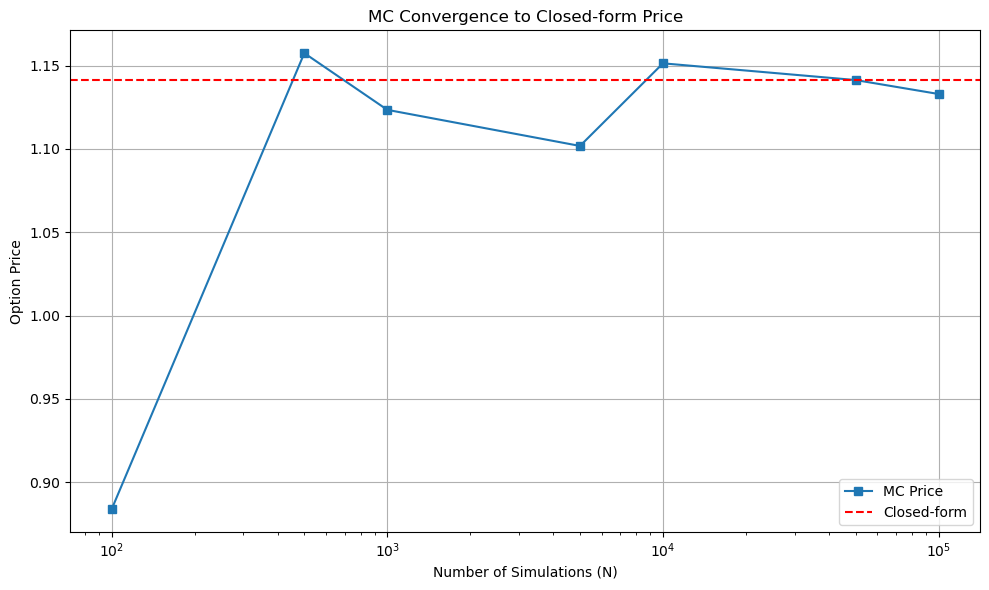

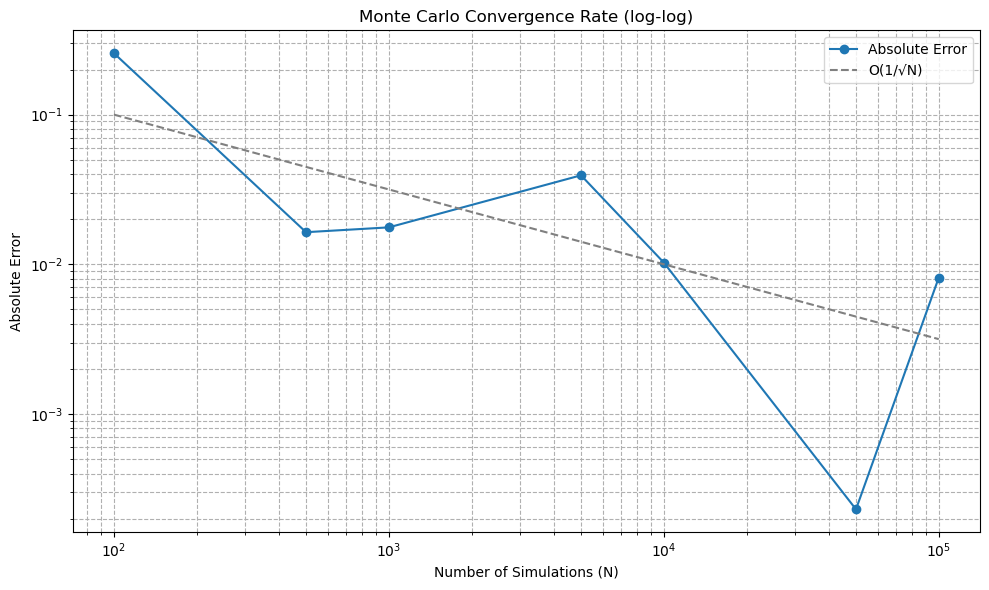

In [103]:
S0, K, B, r, sigma, T = 100, 100, 120, 0.02, 0.2, 1.0
m = 100
Ns = [100, 500, 1000, 5000, 10000, 50000, 100000]

true_price = barrier_up_out_call_analytical_formula(S0, K, B, r, sigma, T)

mc_prices, mc_errors, abs_errors = [], [], []

np.random.seed(42)

for N in Ns:
    price, err = barrier_up_out_call_mc(S0, K, B, r, sigma, T, m=m, N=N, corrected=True)
    mc_prices.append(price)
    mc_errors.append(err)
    abs_errors.append(abs(price - true_price))

plt.figure(figsize=(10, 6))
plt.plot(Ns, mc_prices, marker='s', label='MC Price')
plt.axhline(true_price, color='red', linestyle='--', label='Closed-form')
plt.xscale('log')
plt.xlabel('Number of Simulations (N)')
plt.ylabel('Option Price')
plt.title('MC Convergence to Closed-form Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.loglog(Ns, abs_errors, marker='o', label='Absolute Error')
plt.loglog(Ns, [1/np.sqrt(N) for N in Ns], linestyle='--', label='O(1/√N)', color='gray')
plt.xlabel('Number of Simulations (N)')
plt.ylabel('Absolute Error')
plt.title('Monte Carlo Convergence Rate (log-log)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


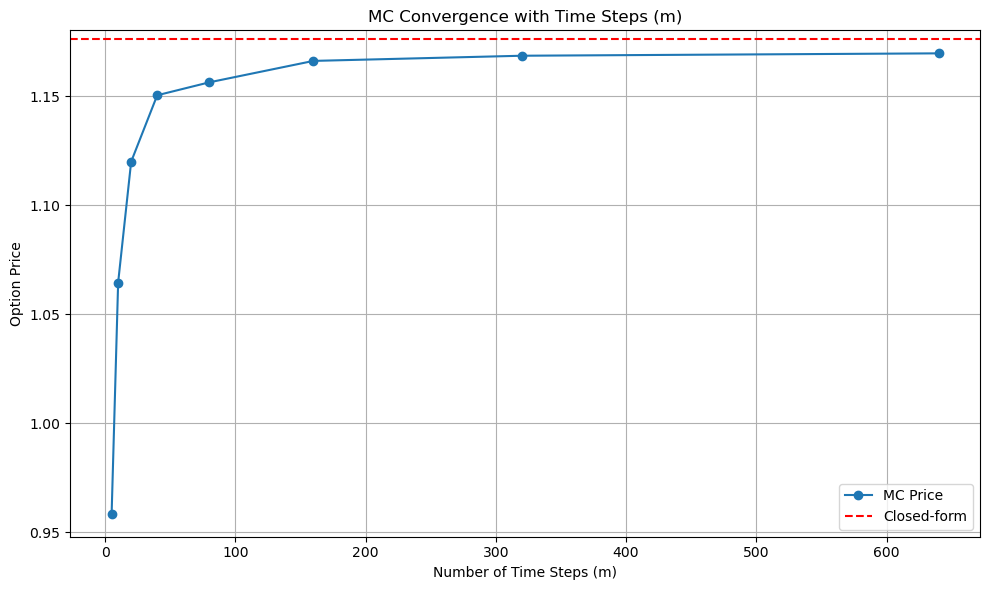

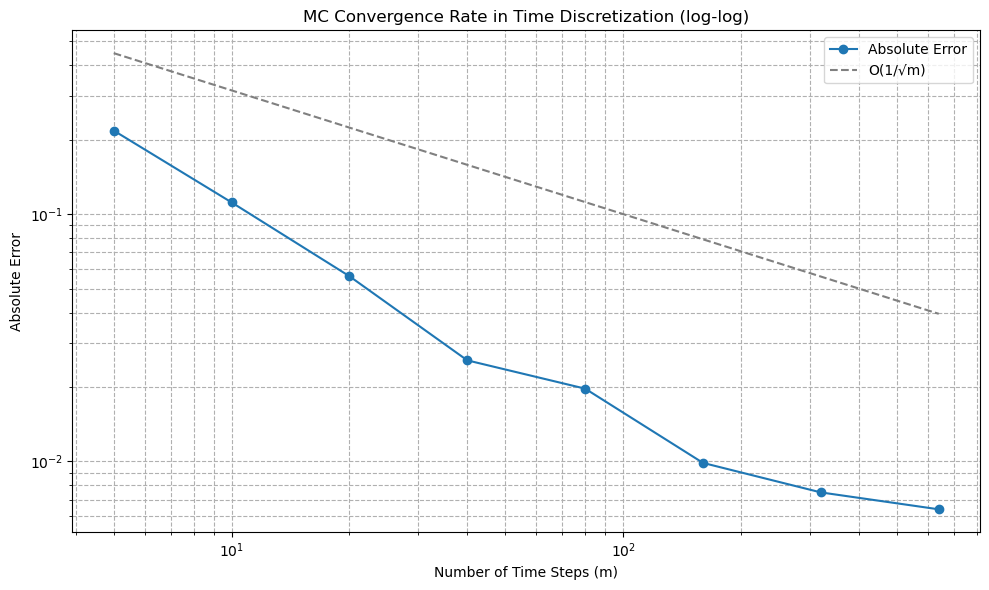

In [105]:
S0, K, B, r, sigma, T = 100, 100, 120, 0.05, 0.2, 1.0
N = 500_000
ms = [5, 10, 20, 40, 80, 160, 320, 640]

true_price = barrier_up_out_call_analytical_formula(S0, K, B, r, sigma, T)

mc_prices_m, mc_errors_m, abs_errors_m = [], [], []

np.random.seed(42)
for m in ms:
    price, err = barrier_up_out_call_mc(S0, K, B, r, sigma, T, m=m, N=N, corrected=True)
    mc_prices_m.append(price)
    mc_errors_m.append(err)
    abs_errors_m.append(abs(price - true_price))

plt.figure(figsize=(10, 6))
plt.plot(ms, mc_prices_m, marker='o', label='MC Price')
plt.axhline(true_price, color='red', linestyle='--', label='Closed-form')
plt.xlabel('Number of Time Steps (m)')
plt.ylabel('Option Price')
plt.title('MC Convergence with Time Steps (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.loglog(ms, abs_errors_m, marker='o', label='Absolute Error')
plt.loglog(ms, [1/np.sqrt(m) for m in ms], linestyle='--', label='O(1/√m)', color='gray')
plt.xlabel('Number of Time Steps (m)')
plt.ylabel('Absolute Error')
plt.title('MC Convergence Rate in Time Discretization (log-log)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


# Question 4:

## Implicit Discretization Scheme

In [106]:
def barrier_option_implicit_scheme(S0, K, B, T, r, sigma, S_max=250, M=2000, N=2000):
    dS = S_max / N
    dt = T / M
    S = np.linspace(0, S_max, N + 1)
    t = np.linspace(0, T, M + 1)
    V = np.zeros((M + 1, N + 1))

    V[-1, S < B] = np.maximum(S[S < B] - K, 0)

    j = np.arange(1, N)
    Sj = j * dS
    lambda_j = 0.5 * dt * sigma**2 * Sj**2 / dS**2

    lower = -lambda_j[1:]
    main = 1 + 2 * lambda_j
    upper = -lambda_j[:-1]
    A = sp.diags([lower, main, upper], offsets=[-1, 0, 1], format="csc")

    for n in reversed(range(M)):
        # Dirichlet boundary conditions
        #V[n, 0] = 0.0
        #V[n, -1] = 0.0
        V[n, S >= B] = 0.0  # barrier knocked out

        V[n, 1:N] = spla.spsolve(A, V[n + 1, 1:N])

    price = np.interp(S0, S, V[0, :])
    return price, S, t, V

## Barrier Option Surface

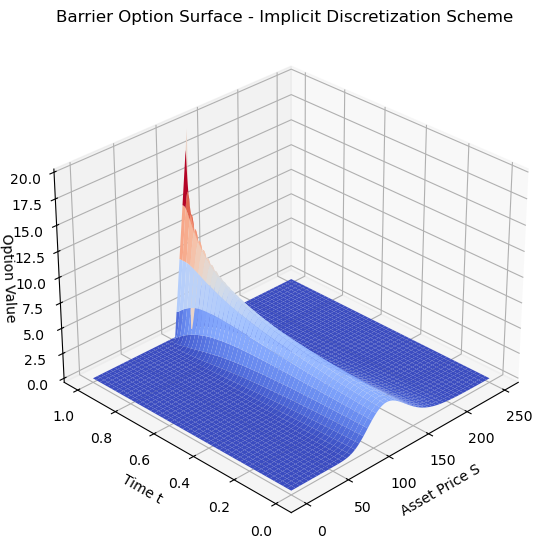

In [113]:
price_barrier, S_imp, t_imp, V_imp = barrier_option_implicit_scheme(S0=100, K=100, B=120, T=1.0, r=0.05, sigma=0.2)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
T_grid, S_grid = np.meshgrid(t_imp, S_imp)
ax.plot_surface(S_grid, T_grid, V_imp.T, cmap=cm.coolwarm)
ax.set_title("Barrier Option Surface - Implicit Discretization Scheme")
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Option Value", labelpad=0)
ax.view_init(elev=30, azim=225)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
plt.show()


## Sensitivity Analysis

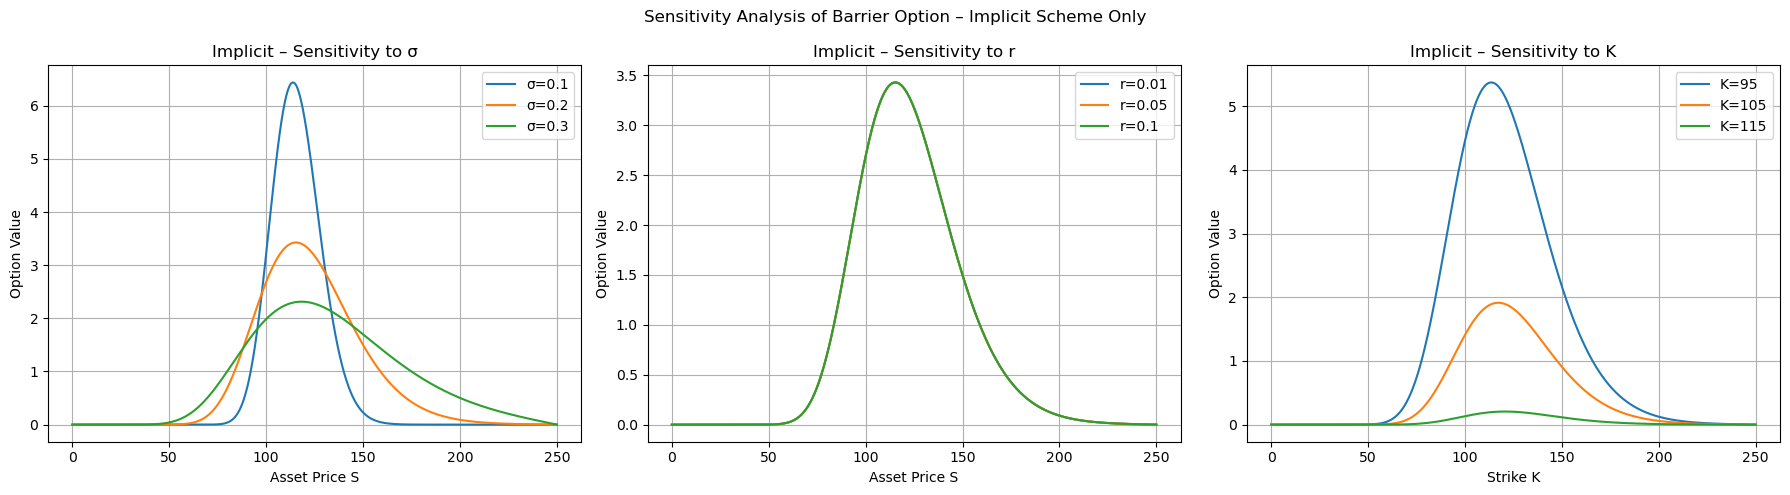

In [111]:
def sensitivity_analysis_comparison():
    S0 = 100
    T = 1.0
    B = 120  # Barrier added
    base_r = 0.05
    base_sigma = 0.2
    base_K = 100

    sigmas = [0.1, 0.2, 0.3]
    rs = [0.01, 0.05, 0.1]
    Ks = [95, 105, 115]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # σ sensitivity
    for sigma in sigmas:
        _, S_sens, _, V_sens = barrier_option_implicit_scheme(S0, base_K, B, T, base_r, sigma)
        axes[0].plot(S_sens, V_sens[0], label=f"σ={sigma}")
    axes[0].set_title("Implicit – Sensitivity to σ")
    axes[0].set_xlabel("Asset Price S")
    axes[0].set_ylabel("Option Value")
    axes[0].legend()
    axes[0].grid(True)

    # r sensitivity
    for r in rs:
        _, S_sens, _, V_sens = barrier_option_implicit_scheme(S0, base_K, B, T, r, base_sigma)
        axes[1].plot(S_sens, V_sens[0], label=f"r={r}")
    axes[1].set_title("Implicit – Sensitivity to r")
    axes[1].set_xlabel("Asset Price S")
    axes[1].set_ylabel("Option Value")
    axes[1].legend()
    axes[1].grid(True)

    # K sensitivity
    for K in Ks:
        _, S_sens, _, V_sens = barrier_option_implicit_scheme(S0, K, B, T, base_r, base_sigma)
        axes[2].plot(S_sens, V_sens[0], label=f"K={K}")
    axes[2].set_title("Implicit – Sensitivity to K")
    axes[2].set_xlabel("Strike K")
    axes[2].set_ylabel("Option Value")
    axes[2].legend()
    axes[2].grid(True)

    plt.suptitle("Sensitivity Analysis of Barrier Option – Implicit Scheme Only")
    plt.tight_layout()
    plt.show()

sensitivity_analysis_comparison()


## Delta Plot

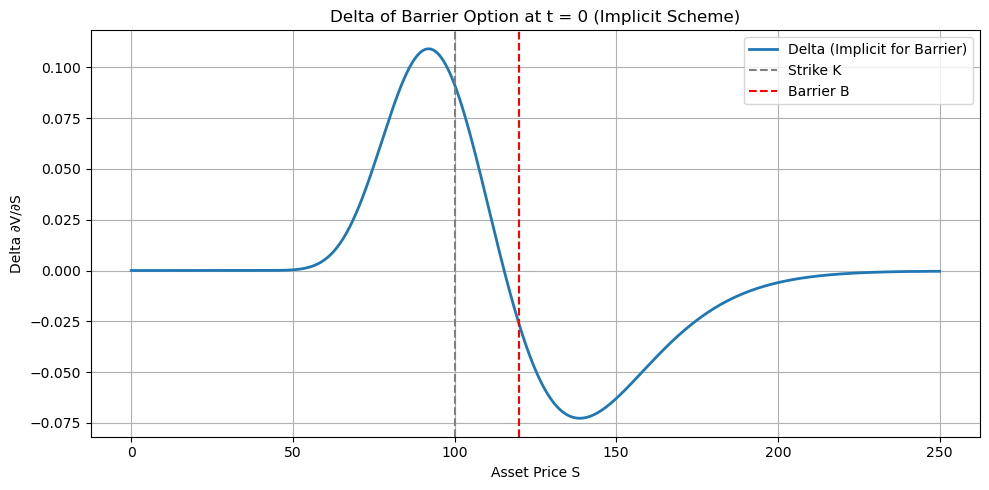

In [109]:
def compute_delta(S, V_row):
    delta = np.zeros_like(V_row)
    delta[1:-1] = (V_row[2:] - V_row[:-2]) / (2 * (S[1] - S[0]))
    delta[0] = (V_row[1] - V_row[0]) / (S[1] - S[0])
    delta[-1] = (V_row[-1] - V_row[-2]) / (S[1] - S[0])
    return delta

S0, K, B, T, r, sigma = 100, 100, 120, 1.0, 0.05, 0.2
price_imp, S_grid, t_grid, V_grid = barrier_option_implicit_scheme(S0, K, B, T, r, sigma)

delta_imp = compute_delta(S_grid, V_grid[0])

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(S_grid, delta_imp, label="Delta (Implicit for Barrier)", linewidth=2)
plt.axvline(K, color="gray", linestyle="--", label="Strike K")
plt.axvline(B, color="red", linestyle="--", label="Barrier B")
plt.xlabel("Asset Price S")
plt.ylabel("Delta ∂V/∂S")
plt.title("Delta of Barrier Option at t = 0 (Implicit Scheme)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()